In [174]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [175]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing packages

In [176]:
import category_encoders
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

### Reading our dataframe

In [317]:
df = pd.read_csv('bank-full.csv')

In [318]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

### Train, test, val split

In [319]:
y = np.array(df['y'])
X = df.drop(['y'],axis=1)

In [320]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

In [321]:
train = X_train.copy()
train['y'] = y_train

val = X_val.copy()
val['y'] = y_val

In [182]:
train_df = train.copy()

### We will encode the categorical features

In [183]:
import category_encoders as ce

import category_encoders as ce

def encoding(df):
    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'unknown': 0, 'primary': 1})
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['contact'] = df['contact'].map({'unknown': 0, 'cellular': 1, 'telephone': 2})
    df['month'] = df['month'].map({'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'oct': 10, 'nov': 11, 'dec': 12, 'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'sep': 9})
    df['poutcome'] = df['poutcome'].map({'unknown': 0, 'failure': 0, 'other': 1, 'success': 2})
    df['y'] = df['y'].map({'no': 0, 'yes': 1})

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)

    df['month_c'] = np.arctan2(df['month_sin'], df['month_cos'])
    df['month_c'] = np.degrees(df['month_c'])
    df['month_c'] = df['month_c'].apply(lambda x: x + 360 if x < 0 else x)

    woe_encoder = ce.WOEEncoder()
    encoded_job = woe_encoder.fit_transform(df['job'], df['y'])
    encoded_marital = woe_encoder.fit_transform(df['marital'], df['y'])
    df['job_encoded'] = encoded_job
    df['marital_encoded'] = encoded_marital

    df = df.drop(['job', 'marital', 'month_sin', 'month_cos'], axis=1)

    return df


### We drop the highly correlated features



In [184]:
def deleting_correlated(df):
  df = df.drop(['pdays'], axis = 1)
  return df

In [185]:
from scipy.stats import mstats

def winsorize_columns(data, lower_limit=0, upper_limit=0.09):
    columns = ['pdays', 'balance', 'campaign', 'previous', 'duration']

    for col in columns:
        data[col] = mstats.winsorize(data[col], limits=[lower_limit, upper_limit])

    return data

In [186]:
from sklearn.preprocessing import StandardScaler
def standardization(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values)
    standardized_df = pd.DataFrame(scaled_data, columns=data.columns)
    return standardized_df

End of the preprocessing

In [333]:
train = encoding(train)
train = winsorize_columns(train)
train = deleting_correlated(train)
train = standardization(train)
train_y = train['y']
train = train.drop('y', axis = 1)

Clustering

In [188]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


def get_sse(df, labels, centroids):
  distances = pairwise_distances(df, centroids)
  squared_errors = np.zeros(df.shape[0])

  for i, label in enumerate(labels):
        centroid = centroids[label]
        distance = distances[i, label]
        squared_error = distance ** 2
        squared_errors[i] = squared_error

  sse = np.sum(squared_errors)
  return sse

In [246]:
from sklearn.metrics import silhouette_score

def calculate_custom_silhouette_score(X, labels):
    silhouette_avg = silhouette_score(X, labels)
    return silhouette_avg

Day and month are irrelevant for in this case, because they do not store any useful information about the data

In [334]:
train = train.drop('day', axis=1)
train = train.drop('month_c', axis=1)
train = train.drop('month', axis=1)

K_means - elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

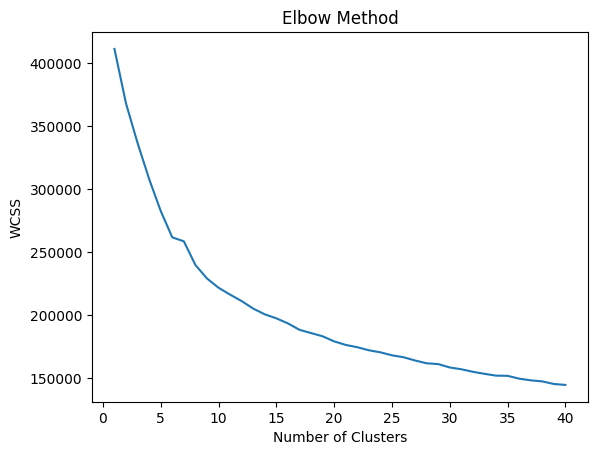

In [191]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow(X, max_clusters):
    wcss = []

    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

max_clusters = 40
plot_elbow(train, max_clusters)


In [339]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(train)

labels = kmeans.labels_

centers = kmeans.cluster_centers_

silhouette_avg = calculate_custom_silhouette_score(train, labels)
print('silhouette_score:', silhouette_avg)

sse = get_sse(train, labels, centers)
print("SSE:", sse)

calinski_score = calinski_harabasz_score(train, labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(train, labels)
print("Davies-Bouldin Index:", davies_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette_score: 0.14040676621662235
SSE: 261672.98689855944
Calinski-Harabasz Index: 3621.2263675034756
Davies-Bouldin Index: 1.8310376724230881


Best scores for k = 6

Feature importance for each cluster

Top 5 most important features for each cluster:

In [341]:
rf_model = RandomForestRegressor()

selected_features = []

for cluster_id in range(k):
    cluster_train = train[labels == cluster_id]
    cluster_train_y = train_y[labels == cluster_id]

    print(f"Cluster {cluster_id}: Number of observations = {cluster_train.shape[0]}")

    rf_model.fit(cluster_train, cluster_train_y)
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': cluster_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    top_features = feature_importance_df['Feature'].head(5).tolist()
    selected_features.append((cluster_id, top_features))

for cluster_id, features in selected_features:
    print(f"Cluster {cluster_id}: Selected Features = {features}")

Cluster 0: Number of observations = 4652
Cluster 1: Number of observations = 7004
Cluster 2: Number of observations = 2299
Cluster 3: Number of observations = 9306
Cluster 4: Number of observations = 564
Cluster 5: Number of observations = 7822
Cluster 0: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 1: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 2: Selected Features = ['duration', 'poutcome', 'balance', 'age', 'job_encoded']
Cluster 3: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 4: Selected Features = ['duration', 'age', 'balance', 'job_encoded', 'campaign']
Cluster 5: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']


Visualisation of the clusters using top 3 features(duration, age and balance dominate the top 3 spots of important features for each cluster):

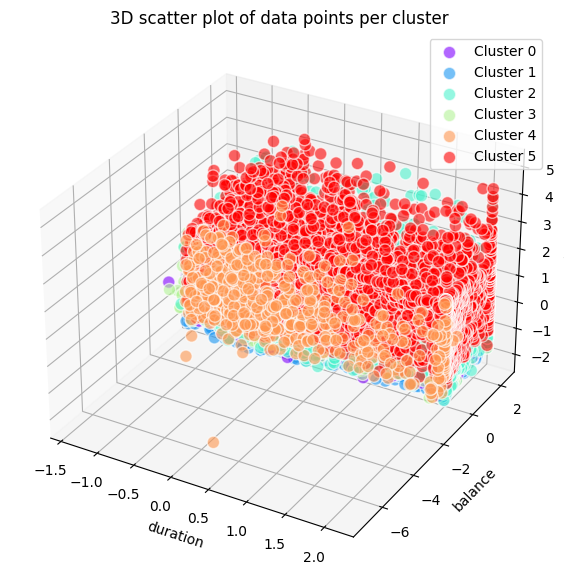

In [257]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

clusters = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    cluster_points = train.loc[labels == cluster]
    ax.scatter(cluster_points['duration'], cluster_points['balance'], cluster_points['age'], color=color, alpha=0.6, edgecolors='w', s=80, label='Cluster {}'.format(cluster))

ax.set_xlabel('duration')
ax.set_ylabel('balance')
ax.set_zlabel('age')

plt.legend()
plt.title('3D scatter plot of data points per cluster')
plt.show()

In [196]:
label_mapping = {
    4.10864835: 'blue-collar',
    2.31287751: 'housemaid',
    0.76752566: 'entrepreneur',
    0.53288965: 'services',
    0.31402544: 'technician',
    0.1437939: 'self-employed',
    -0.16297363: 'admin.',
    -0.20449304: 'unknown',
    -0.57114431: 'management',
    -0.64309931: 'unemployed',
    -0.78519443: 'retired',
    -1.01330501: 'student'
}

In [197]:
import seaborn as sns

Job distribution in each cluster:

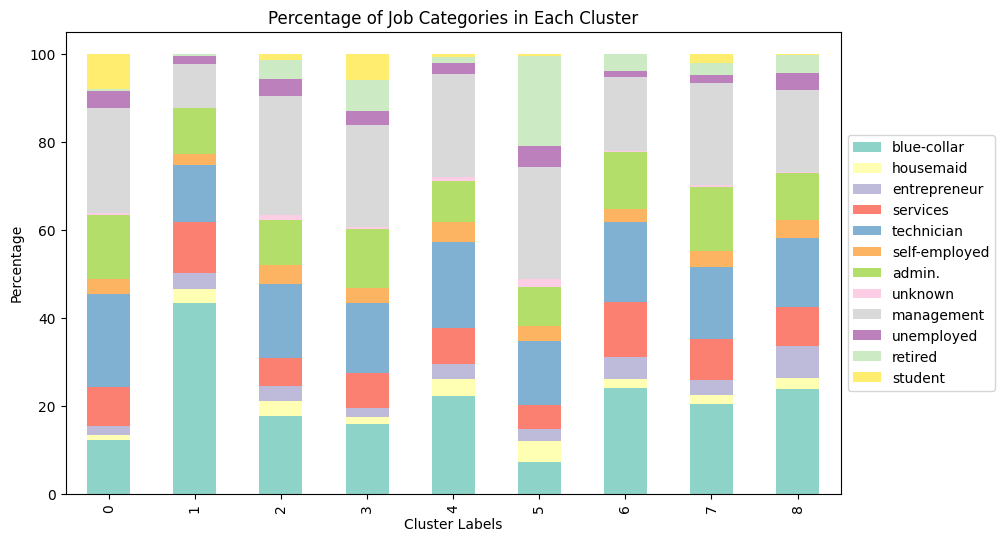

In [198]:
cluster_data = pd.DataFrame({'job_encoded': train['job_encoded'], 'labels': labels})

labelss = [label_mapping[label] for label in sorted(label_mapping.keys(), reverse=True)]
labelss = [labels[0]] * len(cluster_data)

grouped_data = cluster_data.groupby(['labels', 'job_encoded']).size().unstack()

percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

custom_palette = sns.color_palette('Set3', n_colors=len(percentage_data.columns))

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)

plt.xlabel('Cluster Labels')
plt.ylabel('Percentage')
plt.title('Percentage of Job Categories in Each Cluster')

jobs = ['blue-collar', 'housemaid', 'entrepreneur', 'services', 'technician', 'self-employed', 'admin.', 'unknown', 'management', 'unemployed', 'retired', 'student']

plt.legend(jobs, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In k_means method we don't see much difference beetween the clusters, when it comes to job distribution.

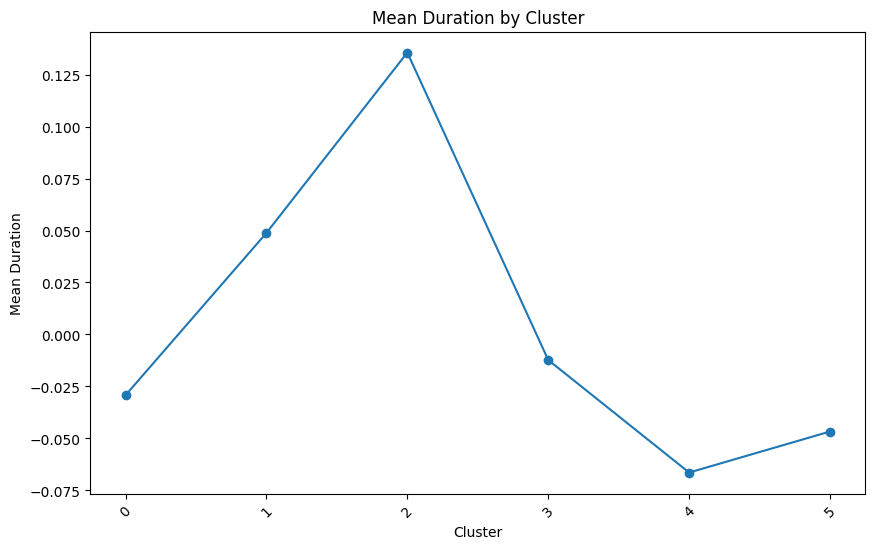

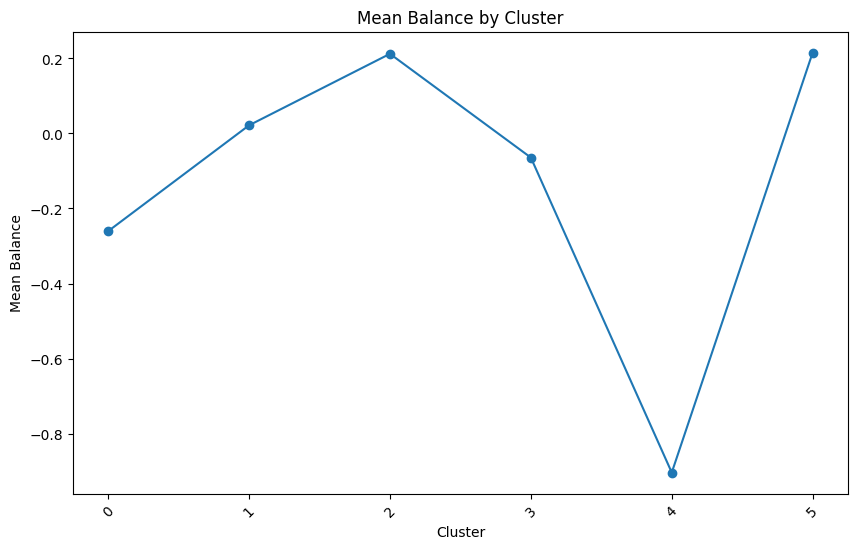

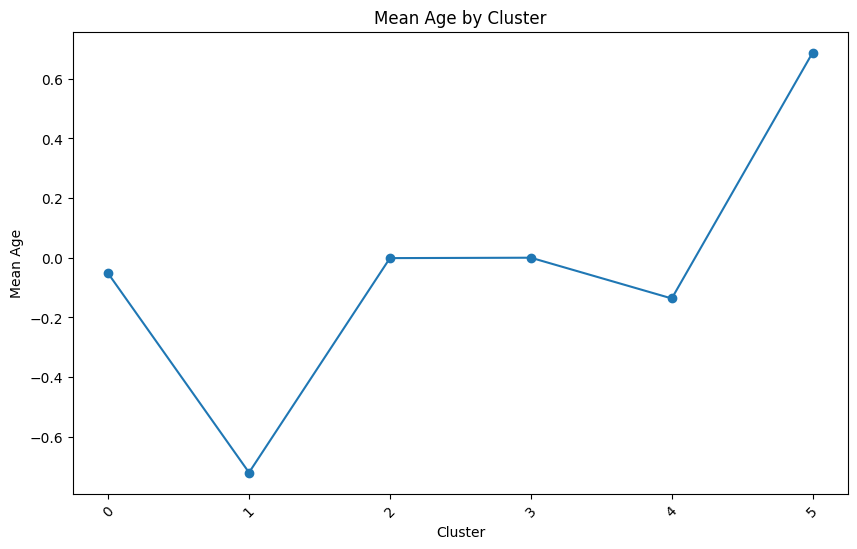

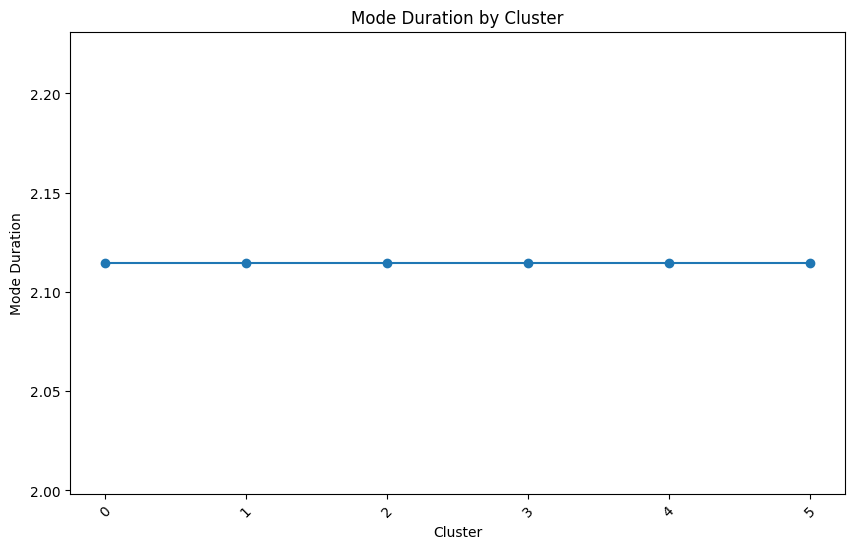

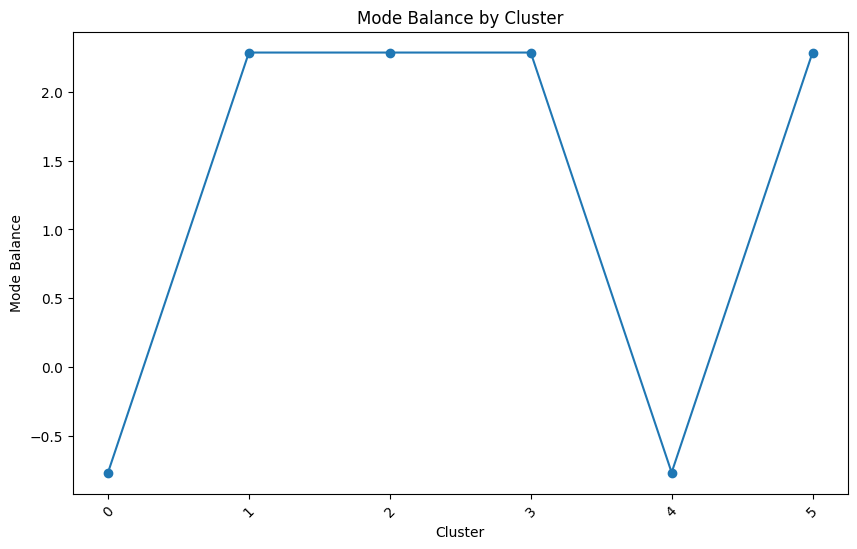

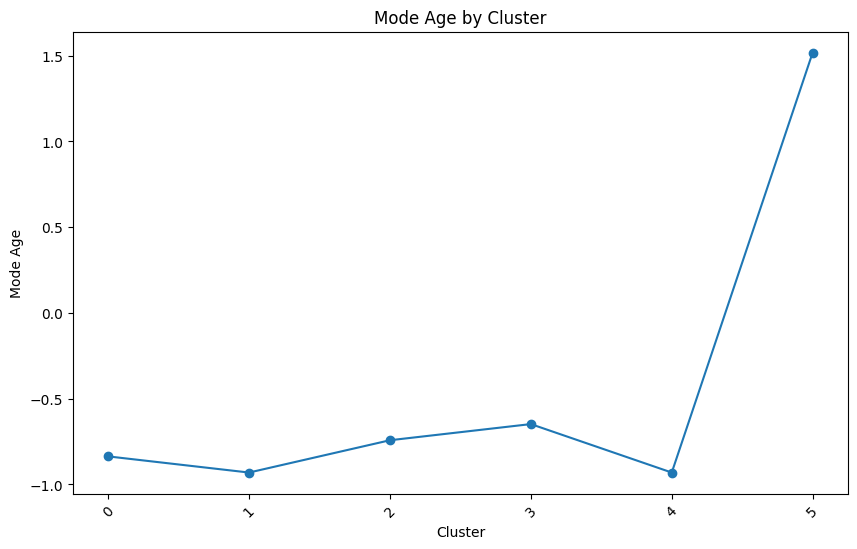

In [342]:
variables = ['duration', 'balance', 'age']
cluster_names = np.unique(labels)

means = train.groupby(labels)[variables].mean()
modes = train.groupby(labels)[variables].agg(lambda x: pd.Series.mode(x)[0])

for variable in variables:
    plt.figure(figsize=(10, 6))
    means_variable = means[variable]
    plt.plot(cluster_names, means_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mean ' + variable.capitalize())
    plt.title('Mean ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

for variable in variables:
    plt.figure(figsize=(10, 6))
    modes_variable = modes[variable]
    plt.plot(cluster_names, modes_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mode ' + variable.capitalize())
    plt.title('Mode ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

From this plot we can see that:
2nd cluster has the greatest duration,
2nd and 5th have the greatest balance,
4th cluster has the smallest balance,
1st cluster is the youngest,
0, 4 have the smallest balance


We can name the clusters:
0 cluster - everything quite low
1 cluster - young, rich
2 cluster - richest
3 cluster - everything about in the middle
4 cluster - poorest
5 cluster - richest, oldest

Visualisation after PCA

In [260]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca_data = pca.fit_transform(train)

explained_variance_ratio = pca.explained_variance_ratio_
variance_preserved = np.sum(explained_variance_ratio) * 100

k = 6
kmeans = KMeans(n_clusters=k)
kmeans.fit(train)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

silhouette_avg = calculate_custom_silhouette_score(train, labels)
print('silhouette_score:', silhouette_avg)

sse = get_sse(train, labels, centers)
print("SSE:", sse)

calinski_score = calinski_harabasz_score(train, labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(train, labels)
print("Davies-Bouldin Index:", davies_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette_score: 0.1277977350548315
SSE: 268520.39347181603
Calinski-Harabasz Index: 3367.4937707826907
Davies-Bouldin Index: 1.9198470220604218


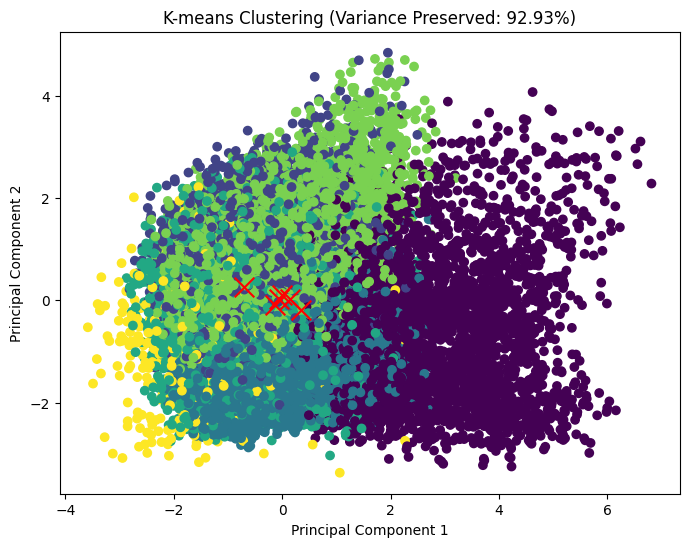

In [261]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200)
plt.title('K-means Clustering (Variance Preserved: {:.2f}%)'.format(variance_preserved))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [262]:
rf_model = RandomForestRegressor()

selected_features = {}

for cluster_id in range(k):
    cluster_train = train[labels == cluster_id]
    cluster_train_y = train_y[labels == cluster_id]

    rf_model.fit(cluster_train, cluster_train_y)
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': cluster_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    top_features = feature_importance_df['Feature'].head(5).tolist()
    selected_features[cluster_id] = top_features

In [263]:
selected_features

{0: ['duration', 'poutcome', 'balance', 'age', 'job_encoded'],
 1: ['duration', 'balance', 'age', 'job_encoded', 'campaign'],
 2: ['duration', 'balance', 'age', 'job_encoded', 'campaign'],
 3: ['duration', 'balance', 'age', 'job_encoded', 'campaign'],
 4: ['duration', 'balance', 'age', 'job_encoded', 'education'],
 5: ['duration', 'age', 'balance', 'job_encoded', 'campaign']}

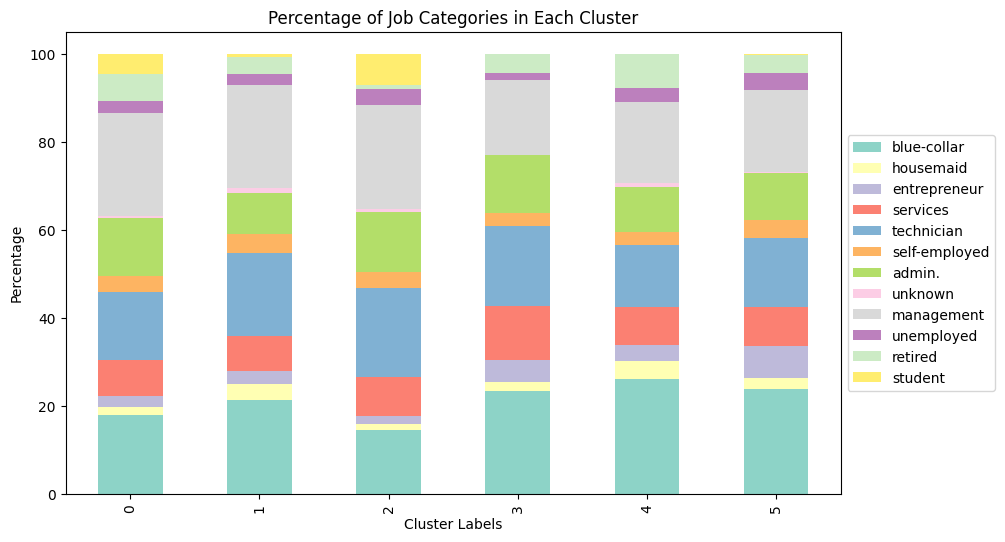

In [264]:
cluster_data = pd.DataFrame({'job_encoded': train['job_encoded'], 'labels': labels})

labelss = [label_mapping[label] for label in sorted(label_mapping.keys(), reverse=True)]
labelss = [labels[0]] * len(cluster_data)

grouped_data = cluster_data.groupby(['labels', 'job_encoded']).size().unstack()

percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

custom_palette = sns.color_palette('Set3', n_colors=len(percentage_data.columns))

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)

plt.xlabel('Cluster Labels')
plt.ylabel('Percentage')
plt.title('Percentage of Job Categories in Each Cluster')

jobs = ['blue-collar', 'housemaid', 'entrepreneur', 'services', 'technician', 'self-employed', 'admin.', 'unknown', 'management', 'unemployed', 'retired', 'student']

plt.legend(jobs, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

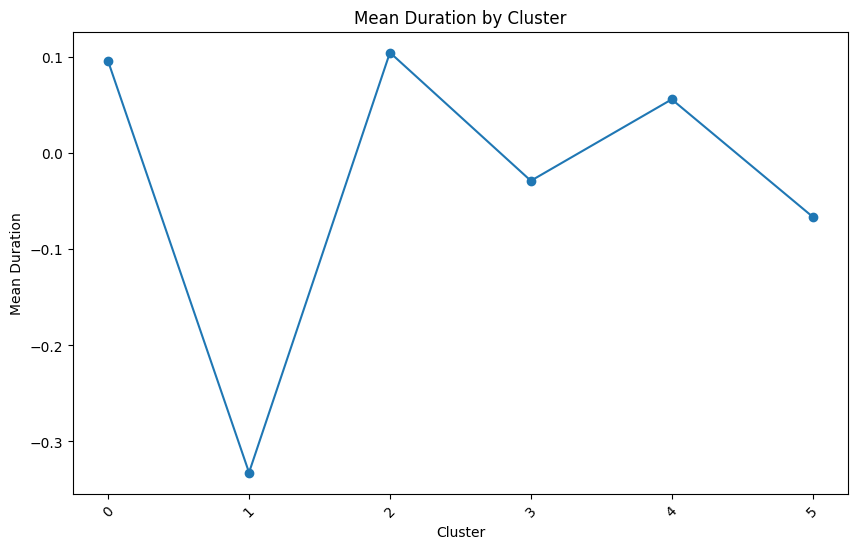

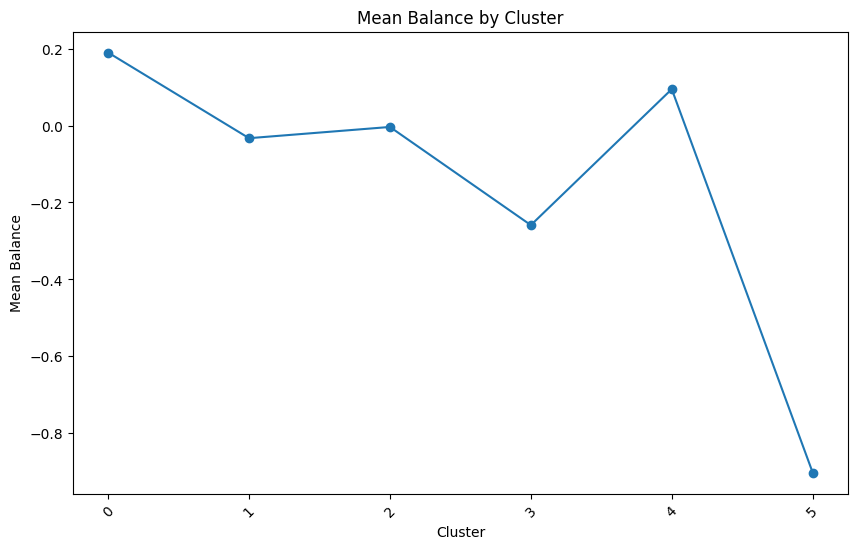

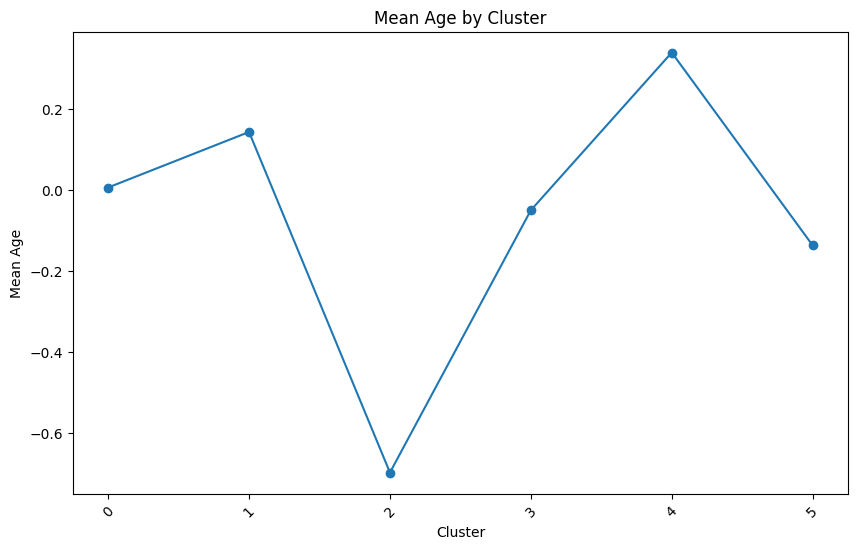

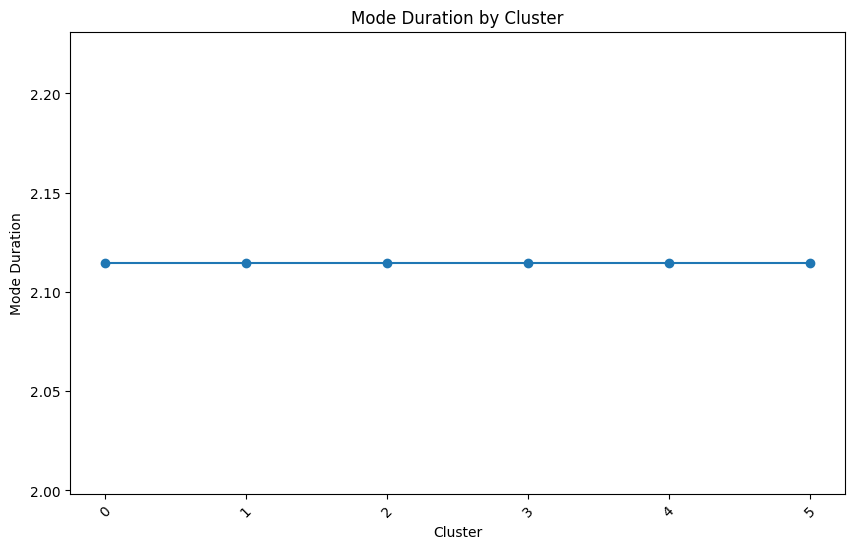

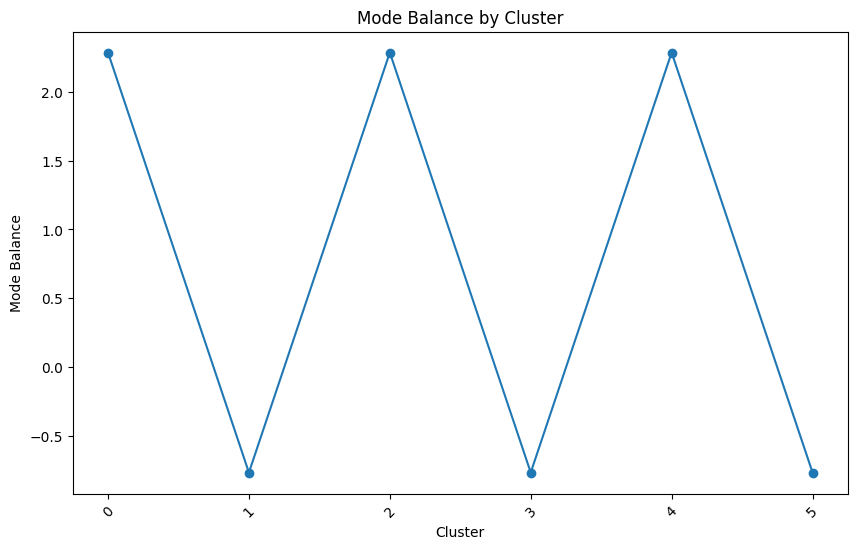

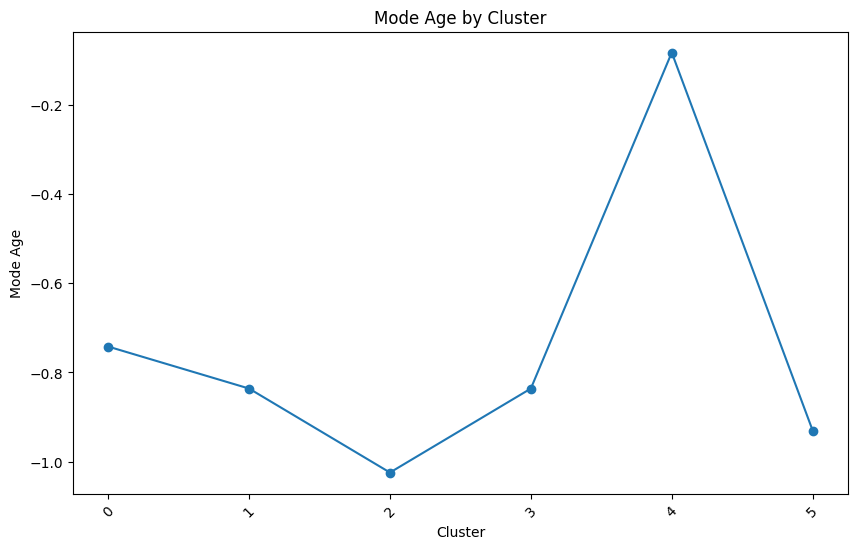

In [265]:
variables = ['duration', 'balance', 'age']
cluster_names = np.unique(labels)

means = train.groupby(labels)[variables].mean()
modes = train.groupby(labels)[variables].agg(lambda x: pd.Series.mode(x)[0])

for variable in variables:
    plt.figure(figsize=(10, 6))
    means_variable = means[variable]
    plt.plot(cluster_names, means_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mean ' + variable.capitalize())
    plt.title('Mean ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

for variable in variables:
    plt.figure(figsize=(10, 6))
    modes_variable = modes[variable]
    plt.plot(cluster_names, modes_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mode ' + variable.capitalize())
    plt.title('Mode ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

Gaussian Mixture

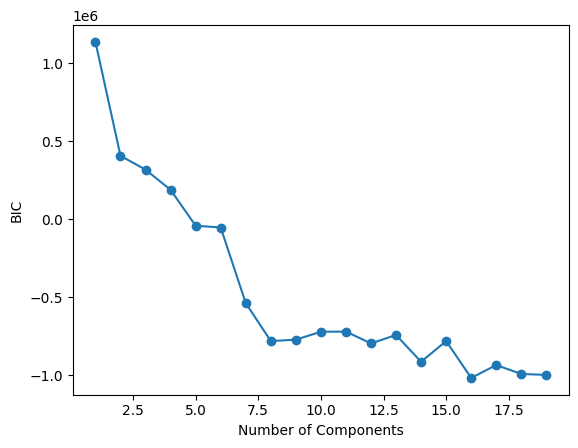

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

n_components = range(1, 20)

bic = []
for n in n_components:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(train)
    bic.append(gmm.bic(train))

plt.plot(n_components, bic, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.show()


In [343]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

num_clusters = 5
gmm = GaussianMixture(n_components=num_clusters, random_state=42)

gmm.fit(train)

labels = gmm.predict(train)

silhouette_avg = silhouette_score(train, labels)
print("Silhouette Score:", silhouette_avg)


calinski_score = calinski_harabasz_score(train, labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(train, labels)
print("Davies-Bouldin Index:", davies_score)

Silhouette Score: 0.12781778662235607
Calinski-Harabasz Index: 3471.5508534027767
Davies-Bouldin Index: 1.935424181772225


In [337]:
rf_model = RandomForestRegressor()

selected_features = []

for cluster_id in range(num_clusters):
    cluster_train = train[labels == cluster_id]
    cluster_train_y = train_y[labels == cluster_id]

    print(f"Cluster {cluster_id}: Number of observations = {cluster_train.shape[0]}")

    rf_model.fit(cluster_train, cluster_train_y)
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': cluster_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    top_features = feature_importance_df['Feature'].head(5).tolist()
    selected_features.append((cluster_id, top_features))

for cluster_id, features in selected_features:
    print(f"Cluster {cluster_id}: Selected Features = {features}")

Cluster 0: Number of observations = 7973
Cluster 1: Number of observations = 11786
Cluster 2: Number of observations = 8986
Cluster 3: Number of observations = 2377
Cluster 4: Number of observations = 525
Cluster 0: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 1: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 2: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 3: Selected Features = ['duration', 'poutcome', 'balance', 'age', 'job_encoded']
Cluster 4: Selected Features = ['duration', 'age', 'balance', 'job_encoded', 'campaign']


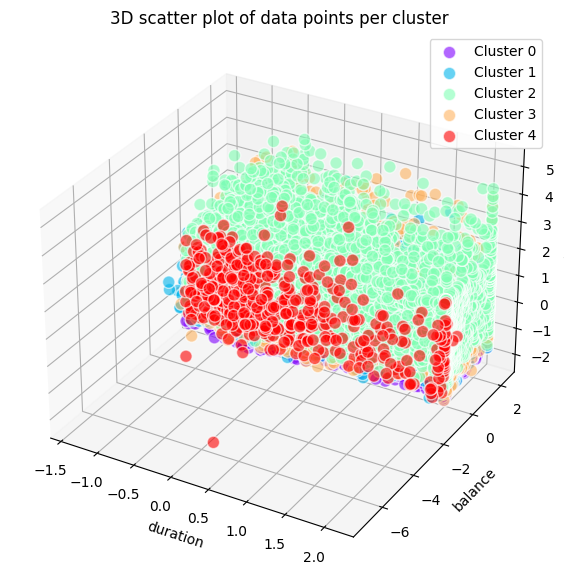

In [272]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

clusters = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    cluster_points = train.loc[labels == cluster]
    ax.scatter(cluster_points['duration'], cluster_points['balance'], cluster_points['age'], color=color, alpha=0.6, edgecolors='w', s=80, label='Cluster {}'.format(cluster))

ax.set_xlabel('duration')
ax.set_ylabel('balance')
ax.set_zlabel('age')

plt.legend()
plt.title('3D scatter plot of data points per cluster')
plt.show()

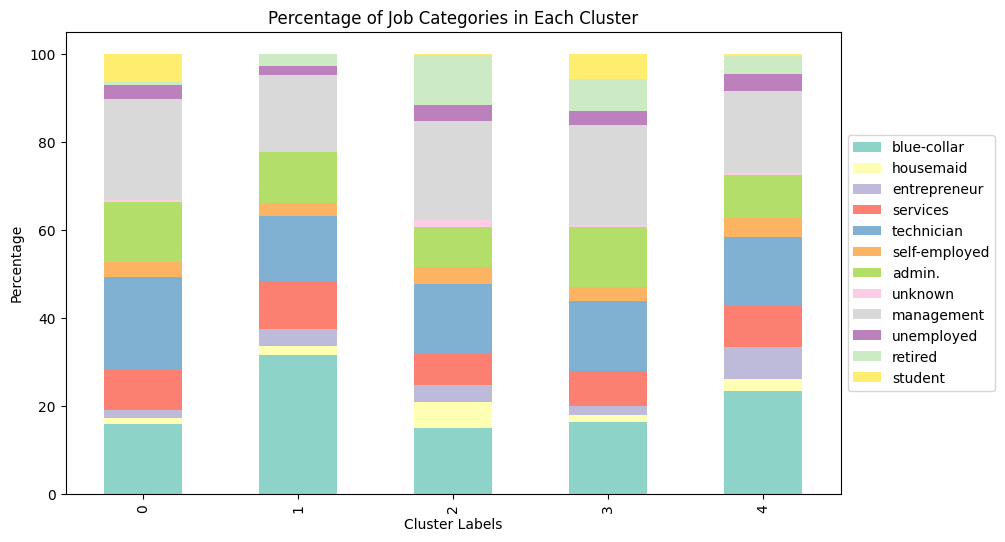

In [338]:
cluster_data = pd.DataFrame({'job_encoded': train['job_encoded'], 'labels': labels})

labelss = [label_mapping[label] for label in sorted(label_mapping.keys(), reverse=True)]
labelss = [labels[0]] * len(cluster_data)

grouped_data = cluster_data.groupby(['labels', 'job_encoded']).size().unstack()

percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

custom_palette = sns.color_palette('Set3', n_colors=len(percentage_data.columns))

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)

plt.xlabel('Cluster Labels')
plt.ylabel('Percentage')
plt.title('Percentage of Job Categories in Each Cluster')

jobs = ['blue-collar', 'housemaid', 'entrepreneur', 'services', 'technician', 'self-employed', 'admin.', 'unknown', 'management', 'unemployed', 'retired', 'student']

plt.legend(jobs, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

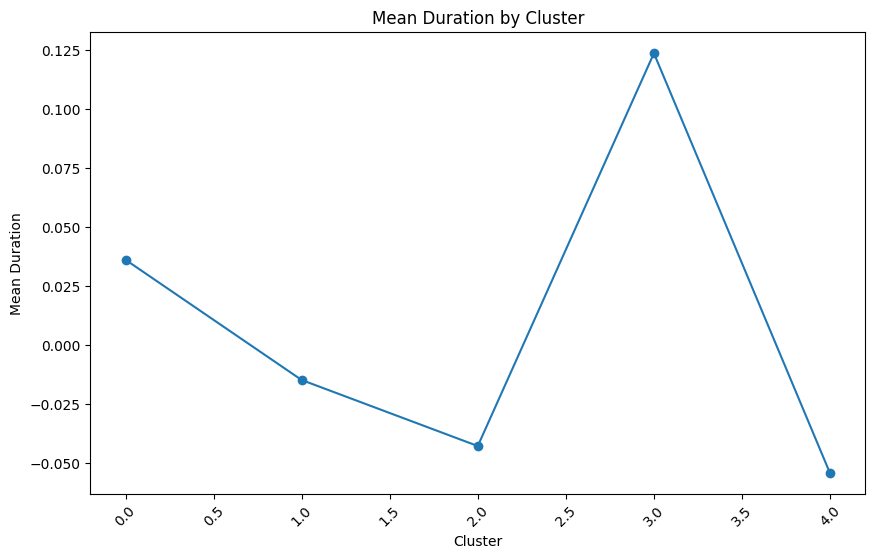

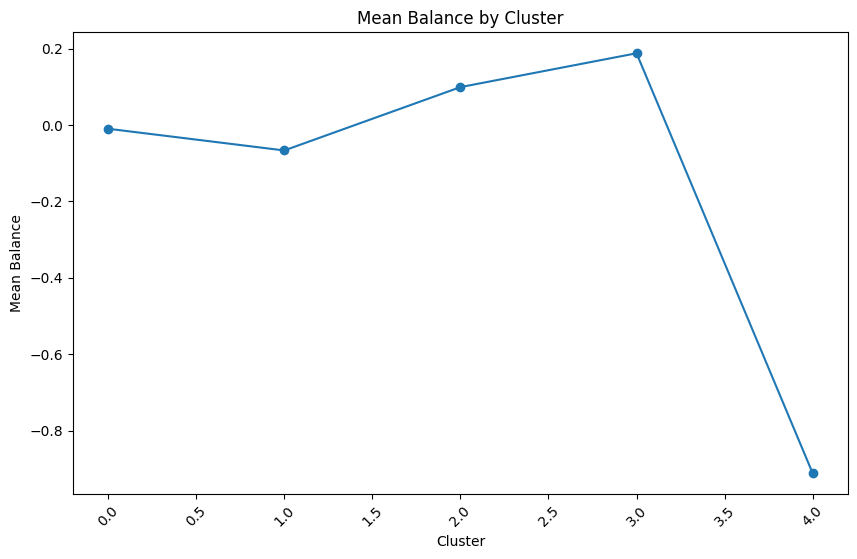

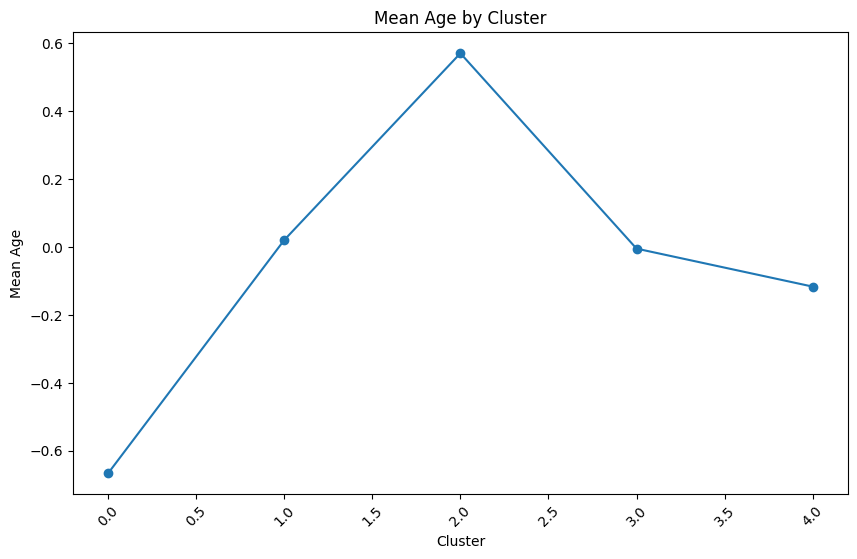

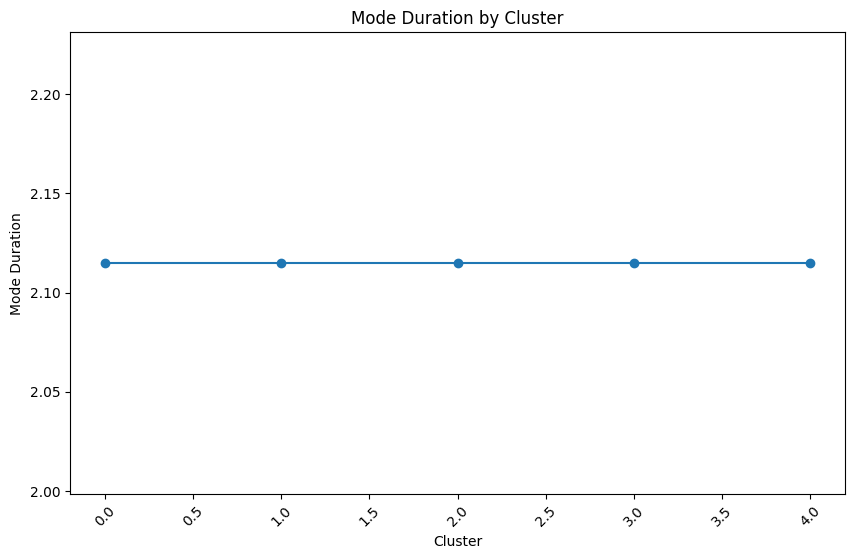

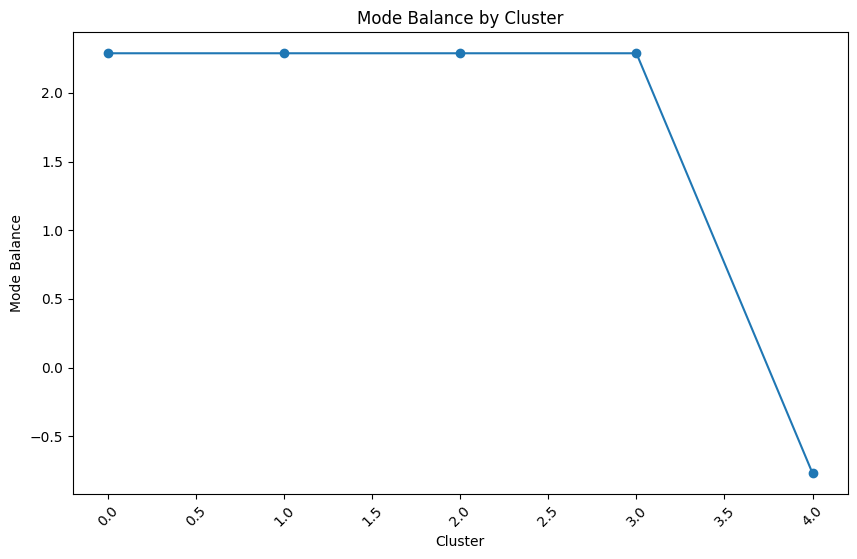

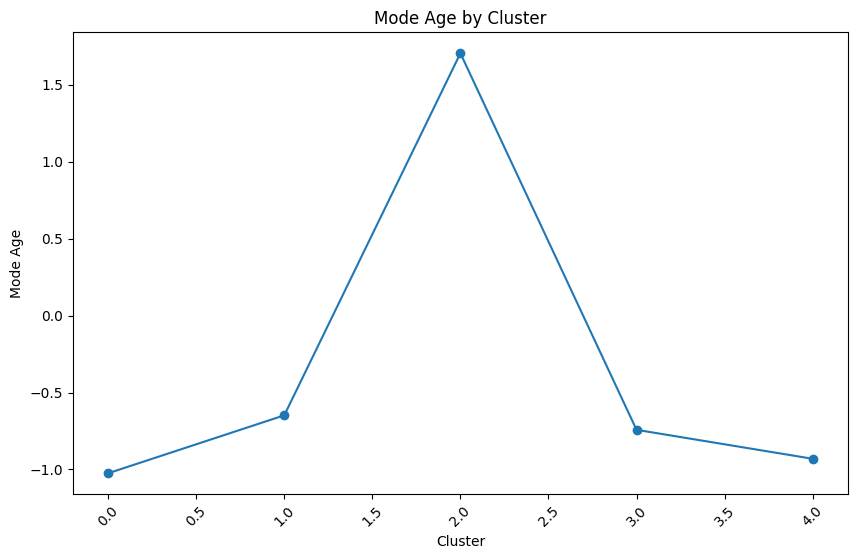

In [344]:
variables = ['duration', 'balance', 'age']
cluster_names = np.unique(labels)

means = train.groupby(labels)[variables].mean()
modes = train.groupby(labels)[variables].agg(lambda x: pd.Series.mode(x)[0])

for variable in variables:
    plt.figure(figsize=(10, 6))
    means_variable = means[variable]
    plt.plot(cluster_names, means_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mean ' + variable.capitalize())
    plt.title('Mean ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

for variable in variables:
    plt.figure(figsize=(10, 6))
    modes_variable = modes[variable]
    plt.plot(cluster_names, modes_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mode ' + variable.capitalize())
    plt.title('Mode ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

From the plots we can see that:
3rd cluster has the greatest duration(mean) and greatest balance,
4th cluster has the smallest duration and balance,
2nd is the oldest almost the richest, and has short duration,
1st is rich, and has both younger and a bit older people (low mode), quite high mean,
0 cluster is rich and young and has average lenght calls


We can name clusters as:
0 cluster - young,
1 cluster - mixed ages,
2 cluster - oldest, quite rich,
3 cluster - richest, longest calls,
4 cluster - poorest, shortest calls,

AgglomerativeClustering

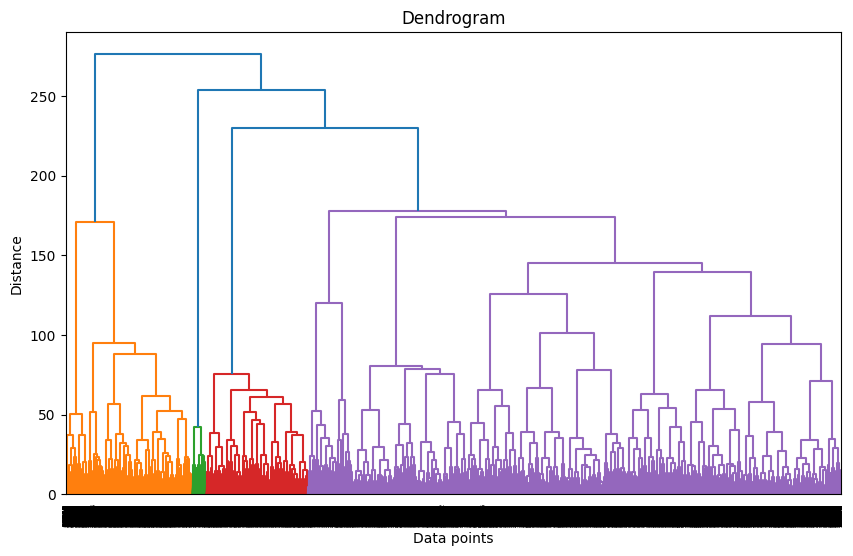

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(train, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()


In [335]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
num_clusters = 7
clustering = AgglomerativeClustering(n_clusters=num_clusters)
labels = clustering.fit_predict(train)

calinski_score = calinski_harabasz_score(train, labels)
davies_score = davies_bouldin_score(train, labels)

print("Calinski-Harabasz Index:", calinski_score)
print("Davies-Bouldin Index:", davies_score)
silhouette_avg = silhouette_score(train, labels)
print("Silhouette Score:", silhouette_avg)

Calinski-Harabasz Index: 2790.476159282257
Davies-Bouldin Index: 1.8997334932778338
Silhouette Score: 0.10657909613289088


In [301]:
rf_model = RandomForestRegressor()

selected_features = []

for cluster_id in range(num_clusters):
    cluster_train = train[labels == cluster_id]
    cluster_train_y = train_y[labels == cluster_id]

    print(f"Cluster {cluster_id}: Number of observations = {cluster_train.shape[0]}")

    rf_model.fit(cluster_train, cluster_train_y)
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': cluster_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    top_features = feature_importance_df['Feature'].head(5).tolist()
    selected_features.append((cluster_id, top_features))

for cluster_id, features in selected_features:
    print(f"Cluster {cluster_id}: Selected Features = {features}")

Cluster 0: Number of observations = 15261
Cluster 1: Number of observations = 1855
Cluster 2: Number of observations = 4620
Cluster 3: Number of observations = 4154
Cluster 4: Number of observations = 4276
Cluster 5: Number of observations = 564
Cluster 6: Number of observations = 917
Cluster 0: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 1: Selected Features = ['duration', 'balance', 'age', 'contact', 'poutcome']
Cluster 2: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 3: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 4: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 5: Selected Features = ['duration', 'age', 'balance', 'job_encoded', 'campaign']
Cluster 6: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']


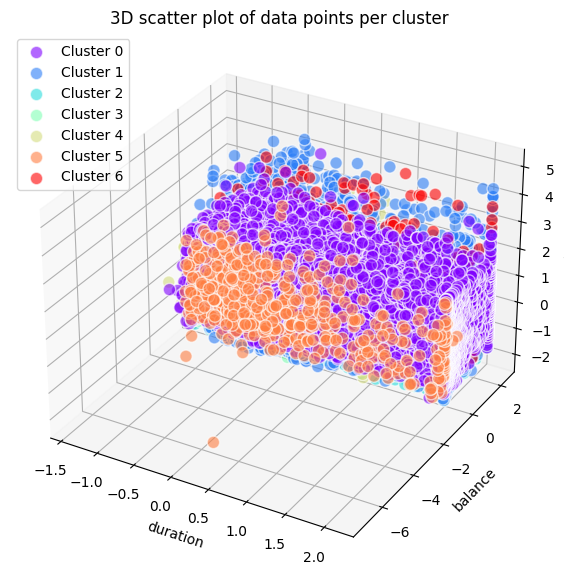

In [293]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

clusters = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    cluster_points = train.loc[labels == cluster]
    ax.scatter(cluster_points['duration'], cluster_points['balance'], cluster_points['age'], color=color, alpha=0.6, edgecolors='w', s=80, label='Cluster {}'.format(cluster))

ax.set_xlabel('duration')
ax.set_ylabel('balance')
ax.set_zlabel('age')

plt.legend()
plt.title('3D scatter plot of data points per cluster')
plt.show()

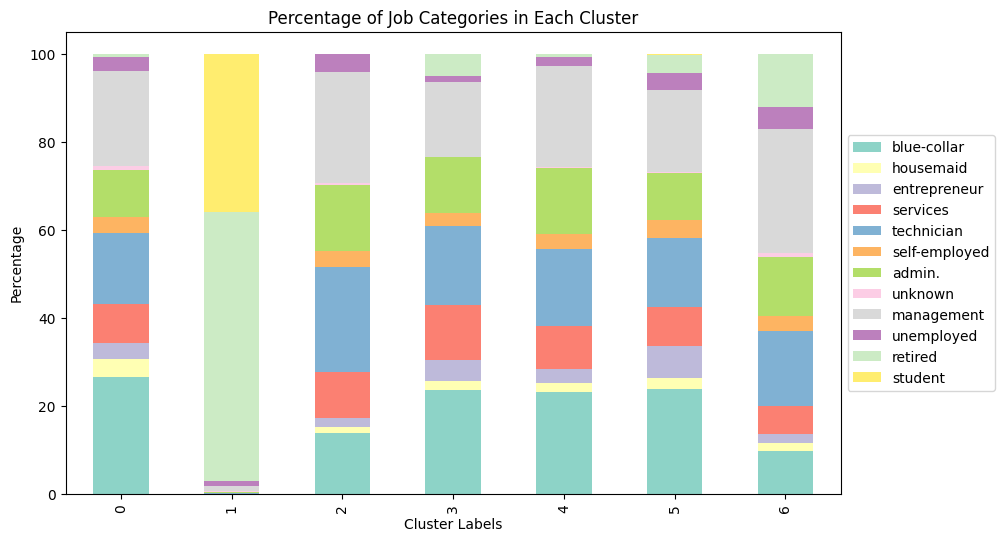

In [294]:
cluster_data = pd.DataFrame({'job_encoded': train['job_encoded'], 'labels': labels})

labelss = [label_mapping[label] for label in sorted(label_mapping.keys(), reverse=True)]
labelss = [labels[0]] * len(cluster_data)

grouped_data = cluster_data.groupby(['labels', 'job_encoded']).size().unstack()

percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

custom_palette = sns.color_palette('Set3', n_colors=len(percentage_data.columns))

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)

plt.xlabel('Cluster Labels')
plt.ylabel('Percentage')
plt.title('Percentage of Job Categories in Each Cluster')

jobs = ['blue-collar', 'housemaid', 'entrepreneur', 'services', 'technician', 'self-employed', 'admin.', 'unknown', 'management', 'unemployed', 'retired', 'student']

plt.legend(jobs, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

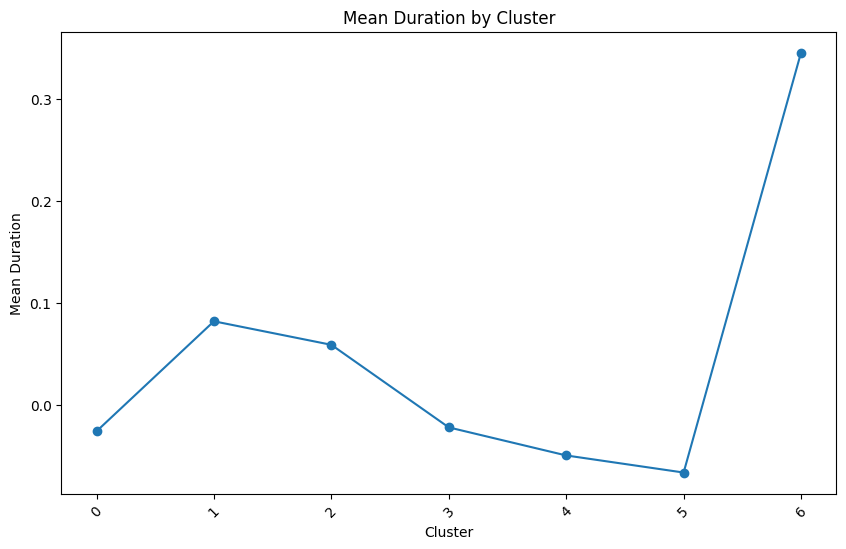

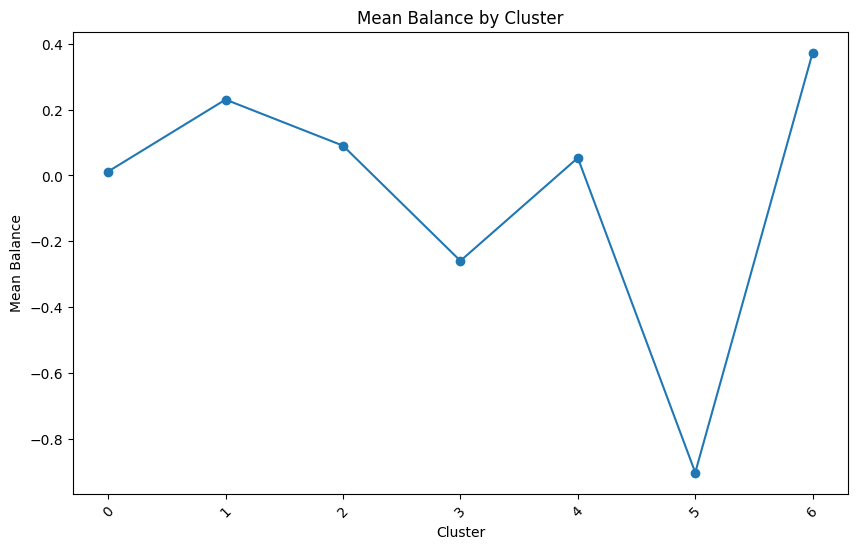

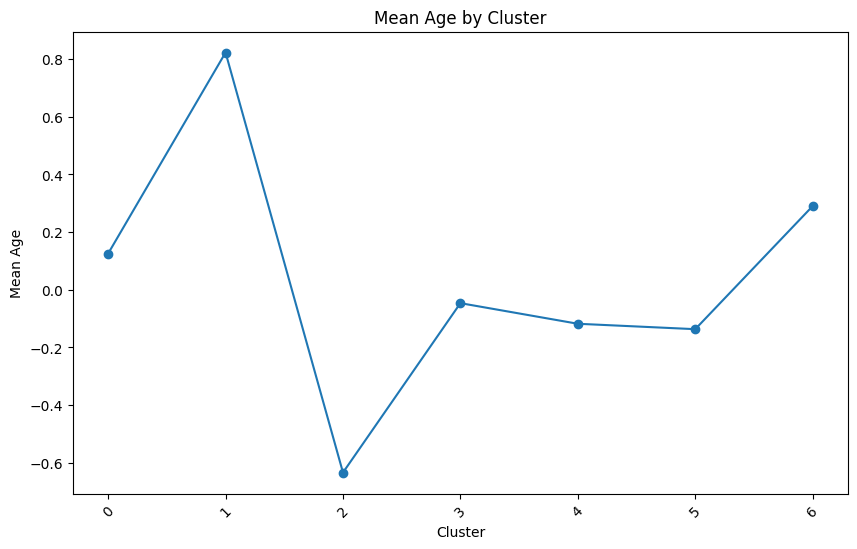

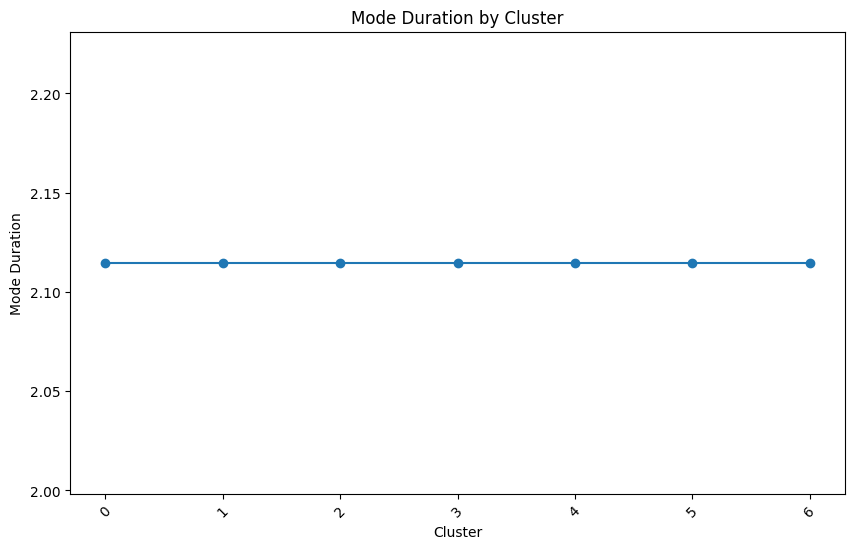

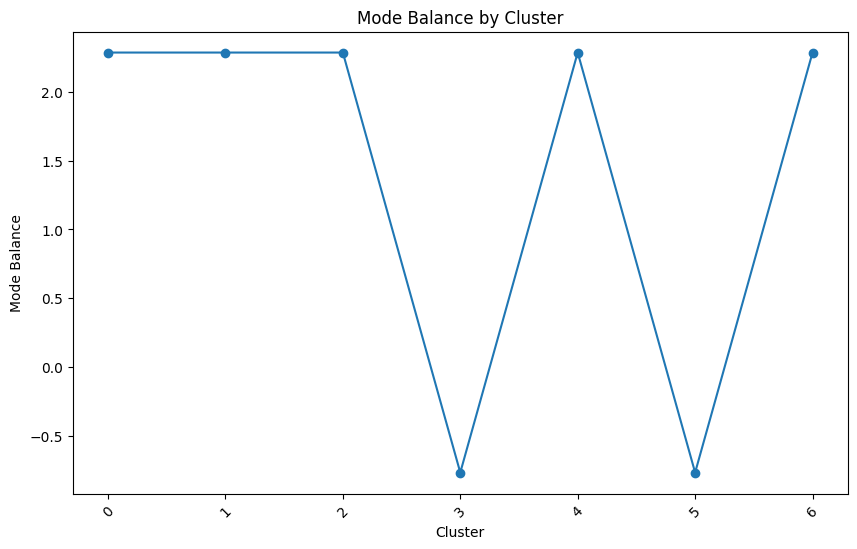

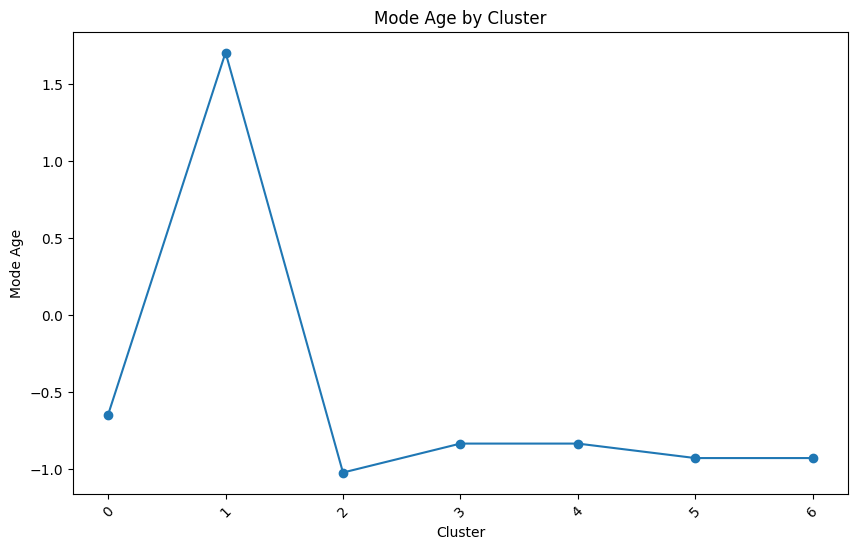

In [218]:
variables = ['duration', 'balance', 'age']
cluster_names = np.unique(labels)

means = train.groupby(labels)[variables].mean()
modes = train.groupby(labels)[variables].agg(lambda x: pd.Series.mode(x)[0])

for variable in variables:
    plt.figure(figsize=(10, 6))
    means_variable = means[variable]
    plt.plot(cluster_names, means_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mean ' + variable.capitalize())
    plt.title('Mean ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

for variable in variables:
    plt.figure(figsize=(10, 6))
    modes_variable = modes[variable]
    plt.plot(cluster_names, modes_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mode ' + variable.capitalize())
    plt.title('Mode ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

From the plots we can tell that:
2nd and 0 clusters are the youngest,
1st cluster is the oldest,
3, 5 clusters have the smallest balance,
1st and 6th cluster have the greatest balance,
6th cluster has the greatest duration

We could name the clusters:
0 cluster - young, quite rich
1 cluster - students + retired people
2 cluster - youngest
3 cluster - poor
4 cluster - rich, quite short
5 cluster - poorest, shortest
6 cluster - longest, richest

SpectralClustering

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ma

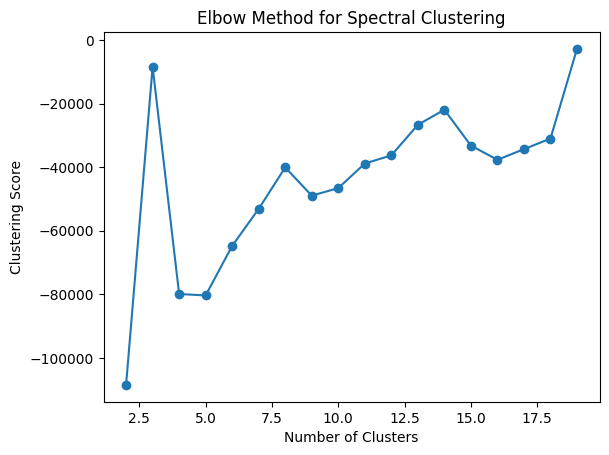

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs

n_clusters = range(2, 20)

clustering_scores = []
for n in n_clusters:
    spectral = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=0)
    labels = spectral.fit_predict(train)
    score = spectral.affinity_matrix_.sum() - spectral.affinity_matrix_[labels, :].sum()
    clustering_scores.append(score)

plt.plot(n_clusters, clustering_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Score')
plt.title('Elbow Method for Spectral Clustering')
plt.show()


In [311]:
from sklearn.cluster import SpectralClustering

spectral_cluster = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', random_state=0)

labels = spectral_cluster.fit_predict(train)

silhouette_avg = silhouette_score(train, labels)
print("Silhouette Score:", silhouette_avg)


calinski_score = calinski_harabasz_score(train, labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(train, labels)
print("Davies-Bouldin Index:", davies_score)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: 0.11577841299363482
Calinski-Harabasz Index: 3060.479682505187
Davies-Bouldin Index: 2.0431371469319592


In [312]:
rf_model = RandomForestRegressor()

selected_features = []

for cluster_id in range(num_clusters):
    cluster_train = train[labels == cluster_id]
    cluster_train_y = train_y[labels == cluster_id]

    print(f"Cluster {cluster_id}: Number of observations = {cluster_train.shape[0]}")

    rf_model.fit(cluster_train, cluster_train_y)
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': cluster_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    top_features = feature_importance_df['Feature'].head(5).tolist()
    selected_features.append((cluster_id, top_features))

for cluster_id, features in selected_features:
    print(f"Cluster {cluster_id}: Selected Features = {features}")

Cluster 0: Number of observations = 4627
Cluster 1: Number of observations = 8028
Cluster 2: Number of observations = 8683
Cluster 3: Number of observations = 5301
Cluster 4: Number of observations = 2335
Cluster 5: Number of observations = 2109
Cluster 6: Number of observations = 564
Cluster 0: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 1: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 2: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 3: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 4: Selected Features = ['duration', 'poutcome', 'balance', 'age', 'job_encoded']
Cluster 5: Selected Features = ['duration', 'balance', 'age', 'job_encoded', 'campaign']
Cluster 6: Selected Features = ['duration', 'age', 'balance', 'job_encoded', 'campaign']


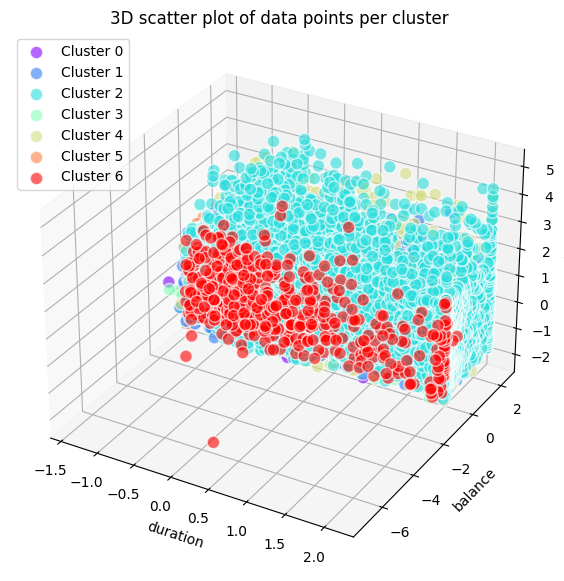

In [313]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

clusters = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    cluster_points = train.loc[labels == cluster]
    ax.scatter(cluster_points['duration'], cluster_points['balance'], cluster_points['age'], color=color, alpha=0.6, edgecolors='w', s=80, label='Cluster {}'.format(cluster))

ax.set_xlabel('duration')
ax.set_ylabel('balance')
ax.set_zlabel('age')

plt.legend()
plt.title('3D scatter plot of data points per cluster')
plt.show()

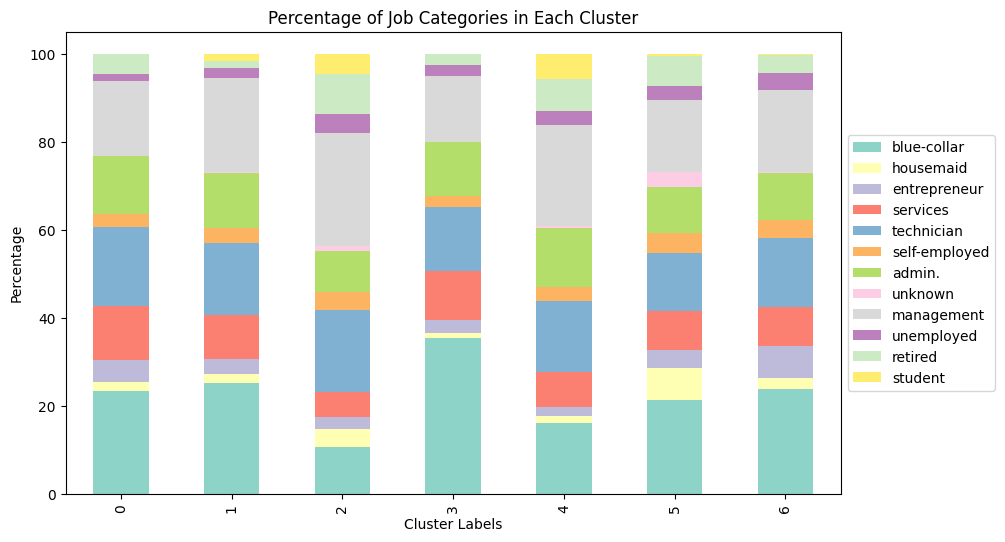

In [314]:
cluster_data = pd.DataFrame({'job_encoded': train['job_encoded'], 'labels': labels})

labelss = [label_mapping[label] for label in sorted(label_mapping.keys(), reverse=True)]
labelss = [labels[0]] * len(cluster_data)

grouped_data = cluster_data.groupby(['labels', 'job_encoded']).size().unstack()

percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

custom_palette = sns.color_palette('Set3', n_colors=len(percentage_data.columns))

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)

plt.xlabel('Cluster Labels')
plt.ylabel('Percentage')
plt.title('Percentage of Job Categories in Each Cluster')

jobs = ['blue-collar', 'housemaid', 'entrepreneur', 'services', 'technician', 'self-employed', 'admin.', 'unknown', 'management', 'unemployed', 'retired', 'student']

plt.legend(jobs, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

The job distribution doesn't show much difference between clusters.

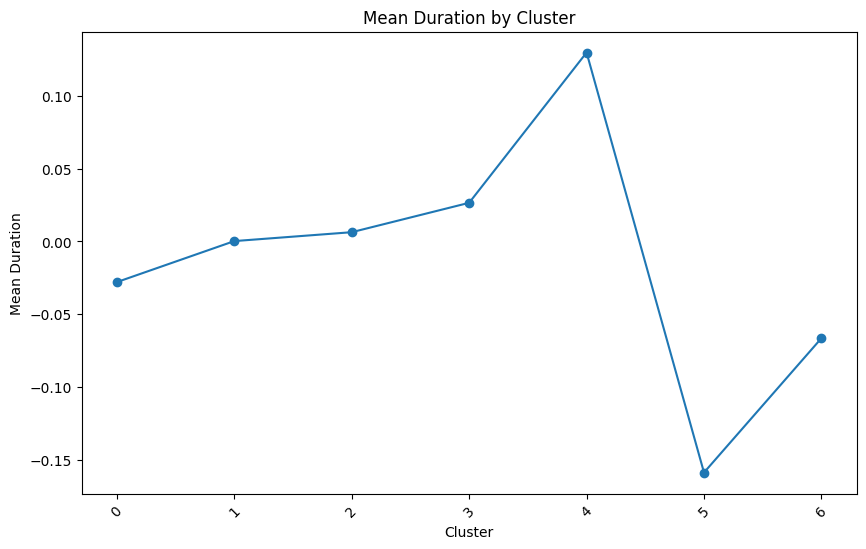

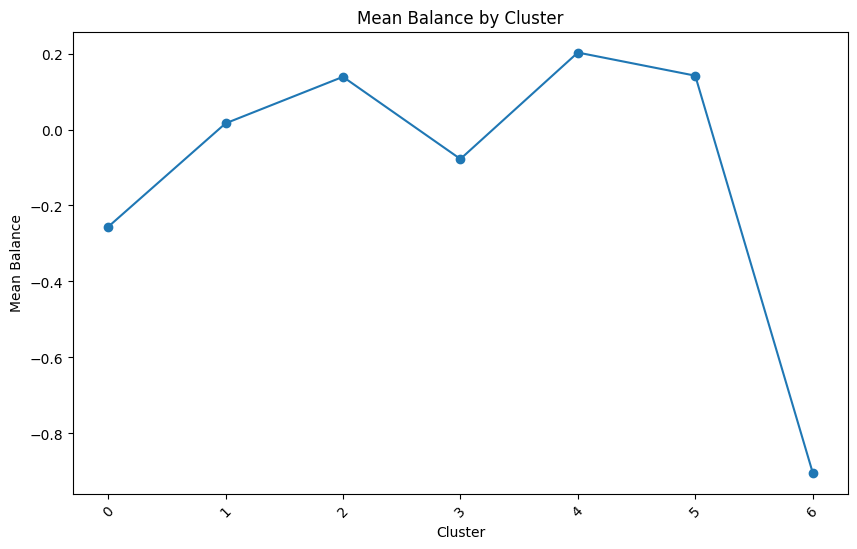

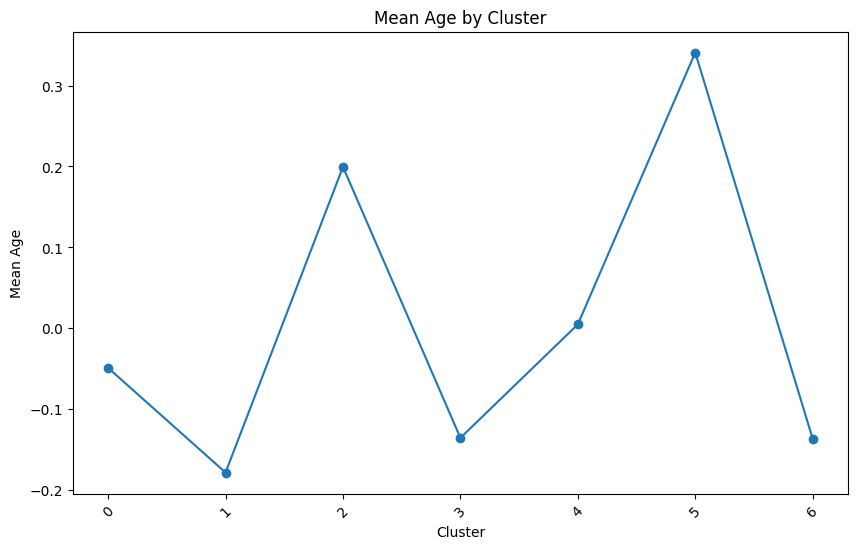

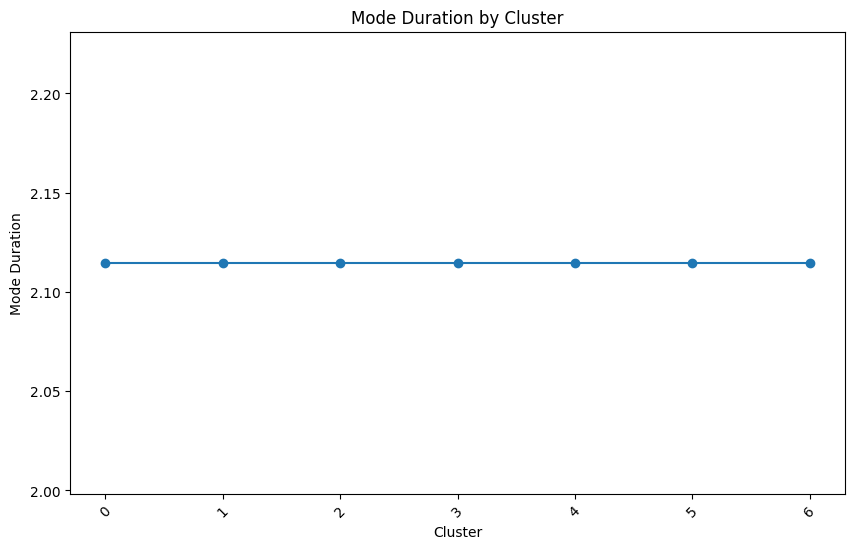

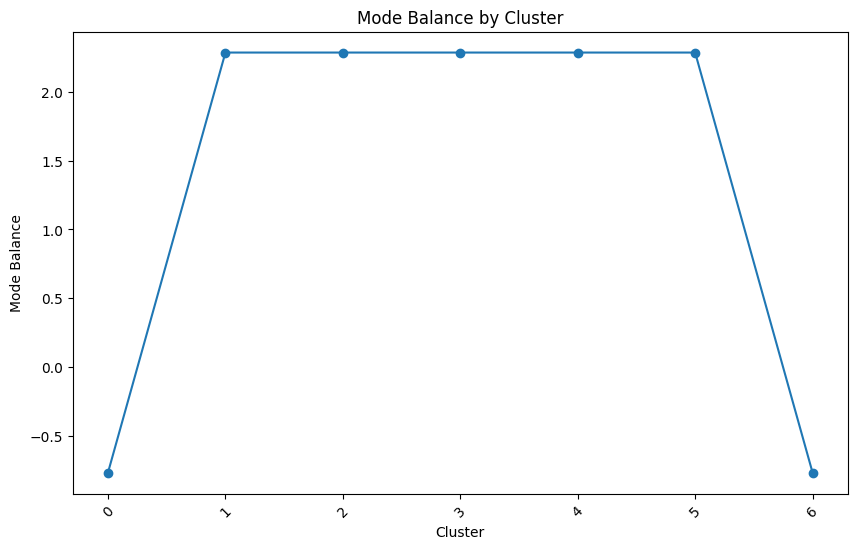

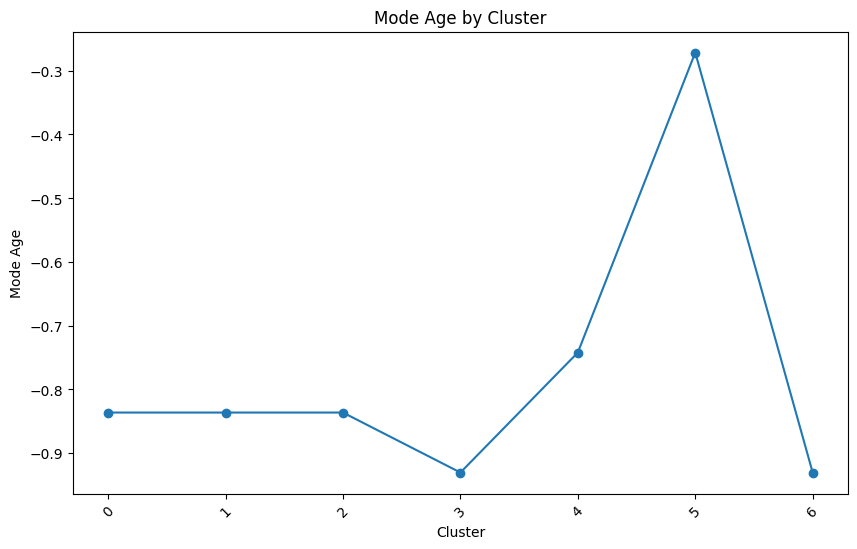

In [315]:
variables = ['duration', 'balance', 'age']
cluster_names = np.unique(labels)

means = train.groupby(labels)[variables].mean()
modes = train.groupby(labels)[variables].agg(lambda x: pd.Series.mode(x)[0])

for variable in variables:
    plt.figure(figsize=(10, 6))
    means_variable = means[variable]
    plt.plot(cluster_names, means_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mean ' + variable.capitalize())
    plt.title('Mean ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

for variable in variables:
    plt.figure(figsize=(10, 6))
    modes_variable = modes[variable]
    plt.plot(cluster_names, modes_variable, marker='o')
    plt.xlabel('Cluster')
    plt.ylabel('Mode ' + variable.capitalize())
    plt.title('Mode ' + variable.capitalize() + ' by Cluster')
    plt.xticks(rotation=45)
    plt.show()

From these plots, we ca see:

From the plots we can see:
4th cluster has the highest duration(mean),
5th cluster has the lowest duration(mean),
5th cluster has the oldest(mode),
3rd and 6th have the youngest (mode, mean),
0 and 6th clusters have lowest balance(mode),
1, 3, 6, are younger clusters
5 is definitely an older cluster
6th cluster has the smallest balance
2nd and 4th have the highest balance

We can try to name them:
0 cluster - poor
1 cluster - youngest
2 cluster - rich
3 cluster - young
4 cluster - longest, richest
5 cluster - old, shortest
6 cluster - poorest

In [322]:
val = encoding(val)
val_y = val['y']
val = val.drop('y', axis = 1)
val = winsorize_columns(val)
val = deleting_correlated(val)
val = standardization(val)

In [323]:
val = val.drop('day', axis = 1)
val = val.drop('month', axis = 1)
val = val.drop('month_c', axis = 1)

K_means

In [324]:
kmeans_validation_labels = kmeans.predict(val)

silhouette_avg = silhouette_score(val, kmeans_validation_labels)
print("Silhouette Score:", silhouette_avg)


calinski_score = calinski_harabasz_score(val, kmeans_validation_labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(val, kmeans_validation_labels)
print("Davies-Bouldin Index:", davies_score)

sse = get_sse(val, kmeans_validation_labels, kmeans.cluster_centers_)
print("SSE:", sse)

kmeans_scores = [silhouette_avg, calinski_score,
                 davies_score, sse]

Silhouette Score: 0.1335522269241096
Calinski-Harabasz Index: 1017.8222299935925
Davies-Bouldin Index: 1.896684045948521
SSE: 80497.03640919847


AgglomerativeClustering

In [326]:
agg_validation_labels = clustering.fit_predict(val)

silhouette_avg = silhouette_score(val, agg_validation_labels)
print("Silhouette Score:", silhouette_avg)


calinski_score = calinski_harabasz_score(val, agg_validation_labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(val, agg_validation_labels)
print("Davies-Bouldin Index:", davies_score)

sse = get_sse2(val, agg_validation_labels, kmeans.cluster_centers_)
print("SSE:", sse)

agg_scores = [silhouette_avg, calinski_score,
                 davies_score, sse]

Silhouette Score: 0.14303929347054167
Calinski-Harabasz Index: 945.9850473925617
Davies-Bouldin Index: 1.939398690615978
SSE: 223161.46298787708


Gaussian Mixture

In [327]:
gmm_validation_labels = gmm.fit_predict(val)

silhouette_avg = silhouette_score(val, gmm_validation_labels)
print("Silhouette Score:", silhouette_avg)

calinski_score = calinski_harabasz_score(val, gmm_validation_labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(val, gmm_validation_labels)
print("Davies-Bouldin Index:", davies_score)

sse = get_sse(val, gmm_validation_labels, gmm.means_)
print("SSE:", sse)

gmm_scores = [silhouette_avg, calinski_score,
              davies_score, sse]

Silhouette Score: 0.13191675720086488
Calinski-Harabasz Index: 988.2576365331746
Davies-Bouldin Index: 2.105793098889695
SSE: 87126.07473853319


SpectralClustering

In [328]:
def get_sse2(df, labels, affinity_matrix):
    distances = pairwise_distances(df, metric='sqeuclidean')
    squared_errors = np.zeros(df.shape[0])

    for i, label in enumerate(labels):
        distance = distances[i, label]
        squared_errors[i] = distance

    sse = np.sum(squared_errors)
    return sse


In [329]:
spectral_validation_labels = spectral_cluster.fit_predict(val)

silhouette_avg = silhouette_score(val, spectral_validation_labels)
print("Silhouette Score:", silhouette_avg)

calinski_score = calinski_harabasz_score(val, spectral_validation_labels)
print("Calinski-Harabasz Index:", calinski_score)

davies_score = davies_bouldin_score(val, spectral_validation_labels)
print("Davies-Bouldin Index:", davies_score)

sse = get_sse2(val, spectral_validation_labels, spectral_cluster.affinity_matrix_)
print("SSE:", sse)

spectral_scores = [silhouette_avg, calinski_score,
                   davies_score, sse]


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: 0.12052075939613953
Calinski-Harabasz Index: 1021.7308753938208
Davies-Bouldin Index: 1.8387670013809647
SSE: 231690.63558528718


Score table

In [330]:
columns = ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 'SSE']
index = ['K-means', 'Agglomerative', 'Gaussian Mixture', 'Spectral Clustering']

score_table = pd.DataFrame(data=[kmeans_scores, agg_scores, gmm_scores, spectral_scores],
                           index=index,
                           columns=columns)

In [331]:
score_table

,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index,SSE
K-means,0.133552,1017.822230,1.896684,80497.036409
Agglomerative,0.143039,945.985047,1.939399,223161.462988
Gaussian Mixture,0.131917,988.257637,2.105793,87126.074739
Spectral Clustering,0.120521,1021.730875,1.838767,231690.635585


Wyniki na zbiorze treningowym:

In [ ]:
Algorithm                 Silhouette Score    Calinski-Harabasz Index   Davies-Bouldin Index
--------------------------------------------------------------------------------------------
k_means                   0.14040676621662235 3621.2263675034756        1.8310376724230881
Gaussian Mixture          0.12781778662235607 3471.5508534027767        1.935424181772225
Agglomerative             0.10657909613289088 2790.476159282257         1.8997334932778338
Spectral Clustering       0.11577841299363482 3060.479682505187         2.0431371469319592
